In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
import os

# Configure TensorFlow to use GPU
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
# Load CSV file
df = pd.read_csv(r"C:\Users\abdel\Downloads\before.csv")

print(df.columns)
for i in range(0, 30883):
    if pd.isnull(df.iloc[i, 0]):
        df.iloc[i, 0] = df.iloc[i, 1]
    elif pd.isnull(df.iloc[i, 1]):
        df.iloc[i, 1] = df.iloc[i, 2]

print(df.isna().sum())
print(df.head())

# Data Cleaning
df['Label'] = df['Label'].astype(str)
df = df[~df['Label'].str.contains('[a-zA-Z]')]
df['Label'] = pd.to_numeric(df['Label'], errors='coerce', downcast='integer')
df['Label'] = df['Label'].astype('float32')
df = df.dropna(subset=['Sentence', 'Label'])

# Tokenization and Padding
max_words = 10000
max_sequence_length = 100
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(df['Sentence'])
sequences = tokenizer.texts_to_sequences(df['Sentence'])
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post', truncating='post')

# RNN Model
embedding_dim = 50 
model = Sequential([
    Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_sequence_length),
    Bidirectional(LSTM(256, return_sequences=True)), 
    Dropout(0.5),
    Bidirectional(LSTM(256)),
    Dense(128, activation='relu'),  # Additional dense layer
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# K-fold 
k_folds =10  
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

# Initialize variables to store metrics
all_tp, all_fp, all_tn, all_fn = 0, 0, 0, 0
overall_accuracy = 0.0  # Initialize overall accuracy variable

for fold, (train_index, test_index) in enumerate(skf.split(padded_sequences, df['Label'])):
    print(f"\nTraining Fold {fold + 1}")
    
    train_padded = padded_sequences[train_index]
    test_padded = padded_sequences[test_index]
    
    labels_train = df['Label'].iloc[train_index]
    labels_test = df['Label'].iloc[test_index]

    # Early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
    
    # Training
    model.fit(train_padded, labels_train, epochs=10, validation_data=(test_padded, labels_test), callbacks=[early_stopping])

    # Evaluate
    test_loss, test_accuracy = model.evaluate(test_padded, labels_test)
    overall_accuracy += test_accuracy  # Accumulate accuracy for each fold
    print(f'Test Accuracy (Fold {fold + 1}): {test_accuracy * 100:.2f}%')

    # Confusion Matrix and Metrics
    predictions = (model.predict(test_padded) > 0.5).astype("int32")
    cm = confusion_matrix(labels_test, predictions)

    tp, fp, fn, tn = cm.ravel()
    all_tp += tp
    all_fp += fp
    all_tn += tn
    all_fn += fn

# Calculate and print overall accuracy
overall_accuracy /= k_folds
print(f'\nOverall Accuracy Across all Folds: {overall_accuracy * 100:.2f}%')

Index(['Sentence', 'Label', 'Unnamed: 2', 'Unnamed: 3'], dtype='object')
Sentence          0
Label             0
Unnamed: 2    30581
Unnamed: 3    30874
dtype: int64
                                            Sentence Label Unnamed: 2  \
0                  " or pg_sleep  (  __TIME__  )  --     1        NaN   
1  create user name identified by pass123 tempora...     1          1   
2   AND 1  =  utl_inaddr.get_host_address   (    ...     1        NaN   
3   select * from users where id  =  '1' or @ @1 ...     1        NaN   
4   select * from users where id  =  1 or 1#"  ( ...     1        NaN   

   Unnamed: 3  
0         NaN  
1         NaN  
2         NaN  
3         NaN  
4         NaN  

Training Fold 1
Epoch 1/10
868/868 [==============================] - 80s 78ms/step - loss: 0.0585 - accuracy: 0.9849 - val_loss: 0.0517 - val_accuracy: 0.9890
Epoch 2/10
868/868 [==============================] - 68s 78ms/step - loss: 0.0194 - accuracy: 0.9959 - val_loss: 0.0191 - val_accuracy: 0

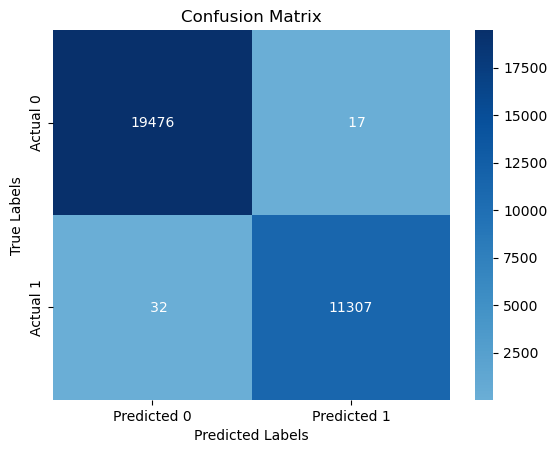

In [2]:
all_tp = int(all_tp)
all_fn = int(all_fn)
all_fp = int(all_fp)
all_tn = int(all_tn)

cm = pd.DataFrame(
    data=[[all_tp , all_fp ], [all_fn ,all_tn ]],
    index=['Actual 0', 'Actual 1'],
    columns=['Predicted 0', 'Predicted 1']
)


sns.heatmap(cm, annot=True,  fmt='5', cmap='Blues', center=True)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [3]:
model.save(r"C:\Users\abdel\Downloads\grm\abdo.h5")
